To begin copy this notebook to your own drive:

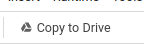


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [ ]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
To: /content/glove.npy
100%|██████████| 480M/480M [00:03<00:00, 129MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 79.6MB/s]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!pip install datasets
!pip install transformers

import transformers
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine


In [ ]:
def get_hidden_state(bert_model, tokenizer, sentence, print_words_ids=False):
  marked_text = "[CLS] " + sentence + " [SEP]"

  encoded_input = tokenizer(marked_text, return_tensors='pt')

  # Split the sentence into tokens.
  tokenized_text = tokenizer.tokenize(marked_text)
  # Map the token strings to their vocabulary indeces.
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  if print_words_ids:
    # Display the words with their indeces.
    for tup in zip(tokenized_text, indexed_tokens):
      print('{:<12} {:>6,}'.format(tup[0], tup[1]))
    # Output
  with torch.no_grad():
    output = model(**encoded_input)
    hidden_states = output[2]
  return hidden_states

# confirm similarity
from scipy.spatial.distance import cosine

def sentence_similarity(sent_sim1,sent_sim2,sent_diff):
  # Calculate the cosine similarity between the word bank 
  # in "bank robber" vs "river bank" (different meanings).
  diff_sentence = 1 - cosine(sent_sim1, sent_diff)

  # Calculate the cosine similarity between the word bank
  # in "bank robber" vs "bank vault" (same meaning).
  similar_sentence = 1 - cosine(sent_sim1, sent_sim2)

  print('Vector similarity for  *similar*  meanings:  %.2f' % similar_sentence)
  print('Vector similarity for *different* meanings:  %.2f' % diff_sentence)

In [ ]:
import transformers
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased",output_hidden_states = True).eval()
text = "Replace me by any text you'd like."
text2 = "switch me with whatever text you would want."
text3 = "Replace me with him in a love text."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

encoded_input = tokenizer(marked_text, return_tensors='pt')

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)
# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

# Output
with torch.no_grad():
  output = model(**encoded_input)
  hidden_states = output[2]

# calc hidden for other 2 sentences
hidden_states2 = get_hidden_state(model,tokenizer,text2)
hidden_states3 = get_hidden_state(model,tokenizer,text3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[CLS]           101
replace       5,672
me            2,033
by            2,011
any           2,151
text          3,793
you           2,017
'             1,005
d             1,040
like          2,066
.             1,012
[SEP]           102


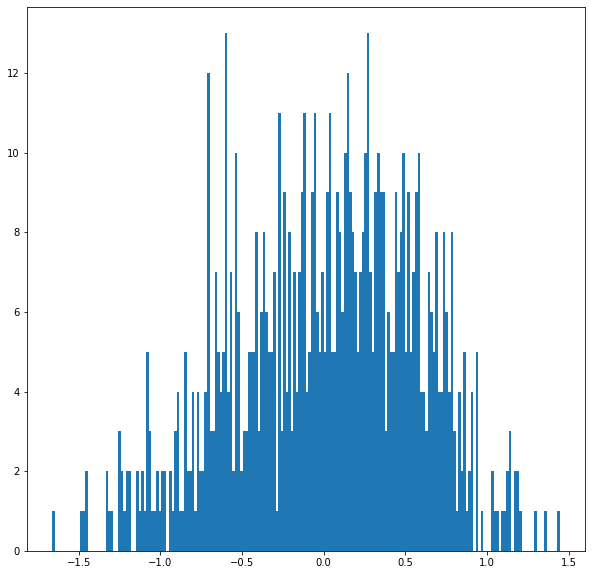

In [ ]:
hidden_states2 = get_hidden_state(model,tokenizer,text2)# For the 5th token in our sentence, select its feature values from layer 0.
token_i = 5
layer_i = 0
batch_i = 0
vec = hidden_states[layer_i][batch_i][token_i]
# print(hidden_states)

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [ ]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

print(token_embeddings.size())
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings = token_embeddings.permute(1,0,2)
print(token_embeddings.size())

# printing word index in sentence
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

torch.Size([13, 1, 14, 768])
torch.Size([14, 13, 768])
0 [CLS]
1 replace
2 me
3 by
4 any
5 text
6 you
7 '
8 d
9 like
10 .
11 [SEP]


In [ ]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-1][0]
token_vecs2 = hidden_states2[-1][0]
token_vecs3 = hidden_states3[-1][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)
sentence_embedding2 = torch.mean(token_vecs2, dim=0)
sentence_embedding3 = torch.mean(token_vecs3, dim=0)



In [ ]:
# confirm similarity
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_sentence = 1 - cosine(sentence_embedding, sentence_embedding3)

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
similar_sentence = 1 - cosine(sentence_embedding, sentence_embedding2)

print('Vector similarity for  *similar*  meanings:  %.2f' % similar_sentence)
print('Vector similarity for *different* meanings:  %.2f' % diff_sentence)

Vector similarity for  *similar*  meanings:  0.90
Vector similarity for *different* meanings:  0.76


In [ ]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
embeddings = model.get_input_embeddings()
print(embeddings)

Embedding(30522, 768, padding_idx=0)


In [ ]:
      # (10): BertLayer(
      #   (attention): BertAttention(
      #     (self): BertSelfAttention(
      #       (query): Linear(in_features=768, out_features=768, bias=True)
      #       (key): Linear(in_features=768, out_features=768, bias=True)
      #       (value): Linear(in_features=768, out_features=768, bias=True)
      #       (dropout): Dropout(p=0.1, inplace=False)
      #     )
      #     (output): BertSelfOutput(
      #       (dense): Linear(in_features=768, out_features=768, bias=True)
      #       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      #       (dropout): Dropout(p=0.1, inplace=False)
      #     )
      #   )
      #   (intermediate): BertIntermediate(
      #     (dense): Linear(in_features=768, out_features=3072, bias=True)
      #   )
      #   (output): BertOutput(
      #     (dense): Linear(in_features=3072, out_features=768, bias=True)
      #     (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      #     (dropout): Dropout(p=0.1, inplace=False)
      #   )

In [ ]:
# model

In [ ]:
# dir(model)

for name,x in model.named_parameters():
  # print()
  if "intermediate.dense" in name  or "output.dense" in name:
    # x = x._set(0)
    print(name)

  # break
  

encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.1.attention.output.dense.weight
encoder.layer.1.attention.output.dense.bias
encoder.layer.1.intermediate.dense.weight
encoder.layer.1.intermediate.dense.bias
encoder.layer.1.output.dense.weight
encoder.layer.1.output.dense.bias
encoder.layer.2.attention.output.dense.weight
encoder.layer.2.attention.output.dense.bias
encoder.layer.2.intermediate.dense.weight
encoder.layer.2.intermediate.dense.bias
encoder.layer.2.output.dense.weight
encoder.layer.2.output.dense.bias
encoder.layer.3.attention.output.dense.weight
encoder.layer.3.attention.output.dense.bias
encoder.layer.3.intermediate.dense.weight
encoder.layer.3.intermediate.dense.bias
encoder.layer.3.output.dense.weight
encoder.layer.3.output.dense.bias
encoder.layer.4.attention.output

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuit

st = model.state_dict()
a = st["encoder.layer.0.attention.output.dense.weight"]
print(a.shape)

torch.Size([768, 768])


In [ ]:
# How to replace the model's weights
st = model.state_dict()
st["encoder.layer.1.intermediate.dense.weight"]  = st["encoder.layer.1.intermediate.dense.weight"]*0
model.load_state_dict(st)
print(model.state_dict()["encoder.layer.1.intermediate.dense.weight"])




tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [-0., 0., 0.,  ..., 0., -0., 0.],
        [-0., 0., -0.,  ..., -0., -0., 0.],
        ...,
        [-0., 0., 0.,  ..., 0., 0., -0.],
        [0., 0., 0.,  ..., -0., 0., 0.],
        [-0., 0., 0.,  ..., -0., -0., -0.]])


In [ ]:
emb = model.get_input_embeddings()
X = emb.weight.cpu().detach().numpy()
# y= st["encoder.layer.2.intermediate.dense.weight"].cpu().numpy()
y= st["encoder.layer.0.attention.output.dense.weight"].cpu().numpy()

In [ ]:
# import sklearn
# from sklearn.linear_model import OrthogonalMatchingPursuit
# print(X.shape)
# print(y.shape)
# mp = OrthogonalMatchingPursuit(normalize=False).fit(X.T, y.T)

In [ ]:
# mp.score(X.T,y.T)

In [ ]:
# j = mp.predict(X.T)
# print(j.dtype)

In [ ]:
# How to replace the model's weights
# print(model.state_dict()["encoder.layer.0.attention.output.dense.weight"])
# st = model.state_dict()
# st["encoder.layer.0.attention.output.dense.weight"]  = torch.Tensor(j.T)
# model.load_state_dict(st)
# print(model.state_dict()["encoder.layer.0.attention.output.dense.weight"])

In [ ]:
# calc hidden for sentences with the model - new weights 
hidden_states = get_hidden_state(model,tokenizer,text)
hidden_states2 = get_hidden_state(model,tokenizer,text2)
hidden_states3 = get_hidden_state(model,tokenizer,text3)


for i in range(13):
  print(f"Layer {i}")
  # # `hidden_states` has shape [13 x 1 x 22 x 768]
  # `token_vecs` is a tensor with shape [22 x 768]

  # take the i'th layer 
  token_vecs = hidden_states[i][0]
  token_vecs2 = hidden_states2[i][0]
  token_vecs3 = hidden_states3[i][0]

  # Calculate the average of all 22 token vectors. - a sentence represntation
  sentence_embedding = torch.mean(token_vecs, dim=0)
  sentence_embedding2 = torch.mean(token_vecs2, dim=0)
  sentence_embedding3 = torch.mean(token_vecs3, dim=0)

  sentence_similarity(sentence_embedding,sentence_embedding2,sentence_embedding3) # Calculate based on cosine similarity

Layer 0
Vector similarity for  *similar*  meanings:  0.87
Vector similarity for *different* meanings:  0.90
Layer 1
Vector similarity for  *similar*  meanings:  0.89
Vector similarity for *different* meanings:  0.89
Layer 2
Vector similarity for  *similar*  meanings:  0.93
Vector similarity for *different* meanings:  0.93
Layer 3
Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.90
Layer 4
Vector similarity for  *similar*  meanings:  0.93
Vector similarity for *different* meanings:  0.88
Layer 5
Vector similarity for  *similar*  meanings:  0.93
Vector similarity for *different* meanings:  0.89
Layer 6
Vector similarity for  *similar*  meanings:  0.93
Vector similarity for *different* meanings:  0.90
Layer 7
Vector similarity for  *similar*  meanings:  0.93
Vector similarity for *different* meanings:  0.88
Layer 8
Vector similarity for  *similar*  meanings:  0.92
Vector similarity for *different* meanings:  0.84
Layer 9
Vector similarity fo

In [ ]:
# Download wikitext dataset
from datasets import list_datasets, load_dataset, list_metrics, load_metric

wikitext_dataset = load_dataset('wikitext', 'wikitext-103-v1')

Reusing dataset wikitext (/root/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# print(wikitext_dataset)
import gc
gc.collect()
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_sentences = wikitext_dataset['test'][4000:5500]['text']
# batch_sentences = [data['text'] for i,data in enumerate(wikitext_dataset['train'][1:1500]]
model.to(device)
output_list = [0]*1500
with torch.no_grad():
  for i,sent in enumerate(batch_sentences):
    encoded_input = tokenizer(sent,return_tensors='pt').to(device)
    output = model(**encoded_input)
    output_list[i] = output[2]

In [ ]:
output_list[i][0].size()

torch.Size([1, 2, 768])